# Introduction
This file provides implementation of CNN architecture  to create a robust model that can effectively recognize single digits (0-9) in images taken from Google Street View.

Import necessay libraries.


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

Set seed for numpy and tensorflow

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

Declare global arrays to hold training/validation/testing datasets.

In [45]:
global train_images
global train_labels
global validation_images
global validation_labels
global test_images
global test_labels

# Load the dataset.
 The images, initially in .png format, were downloaded from the official SVHN dataset repository (http://ufldl.stanford.edu/housenumbers/). Accompanying the images, metadata(.mat) files containing the coordinates of digit bounding boxes were also downloaded. The metadata files (in matfile format) provided precise coordinates for the bounding boxes surrounding each digit within the multi-digit images. Utilizing these coordinates, we used a script to crop the original images accordingly, thereby extracting single-digit images and resizing them to a uniform dimension of 32x32x3 pixels. Each extracted single-digit image was then labeled based on the digit it represented, as indicated in the metadata files.
This repository from GitHub is used to get the matfile to csv conversion : https://github.com/prijip/Py-Gsvhn-DigitStruct-Reader.git.




In [46]:
train_images_short = np.load('.//dataset//train_images_singleImages.npy')
train_labels_short = np.load('.//dataset//train_labels_singleImages.npy')
extra_images = np.load('.//dataset//extra_images_singleImages.npy')
extra_labels = np.load('.//dataset//extra_labels_singleImages.npy')
test_images = np.load('.//dataset//test_images_singleImages.npy')
test_labels = np.load('.//dataset//test_labels_singleImages.npy')

Use extra images (300000) for training. This increases the model accuracy.

In [47]:
EXTRA_DATA = 300000
extra_images = extra_images[0:EXTRA_DATA,...]
extra_labels = extra_labels[0:EXTRA_DATA,...]

In [48]:
print(len(extra_images))

300000


Function to visualize test images

In [49]:
def plotTestImages(n):
    _, axes = plt.subplots(nrows=1, ncols = 10, figsize=(16,4))
    for ax, image, label in zip(axes, test_images[0:n], test_labels):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')
        ax.set_title("Test: %i" % label)

Function to visualize training images

In [50]:
def plotTrainImages(n):
    _, axes = plt.subplots(nrows=1, ncols = 10, figsize=(16,4))
    for ax, image, label in zip(axes, train_images[0:n], train_labels):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')
        ax.set_title("Train: %i" % label)

Function to visualize extra training images

In [51]:

def plotExtraImages(n):
    _, axes = plt.subplots(nrows=1, ncols = 10, figsize=(16,4))
    for ax, image, label in zip(axes, extra_images[0:n], extra_labels):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')
        ax.set_title("Extra: %i" % label)

In [52]:
def plotImages(images, imagelabels, indexes, name):
    selected_images = [images[i] for i in indexes]
    selected_labels = [imagelabels[i] for i in indexes]
    ncols = 10
    if len(images) < 10 :
        ncols = len(images)
    _, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16,4))
    for ax, image, label in zip(axes, selected_images, selected_labels):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{name} label {label}")

Check the shapes of datasets

In [53]:
print(train_images_short.shape)
print(train_labels_short.shape)
print(extra_images.shape)
print(extra_labels.shape)
print(test_labels.shape)
print(test_images.shape)

(68095, 32, 32, 3)
(68095,)
(300000, 32, 32, 3)
(300000,)
(23542,)
(23542, 32, 32, 3)


Concatenate training and extra training array along the rows

In [54]:
train_images = np.vstack((train_images_short, extra_images))
train_labels = np.concatenate((train_labels_short, extra_labels))

print(train_images.shape)
print(train_labels.shape)

(368095, 32, 32, 3)
(368095,)


Visualize train/test/extra train images

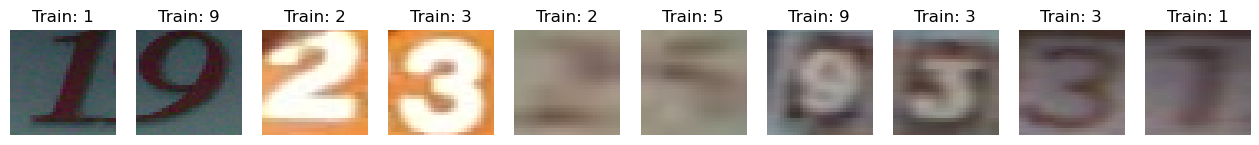

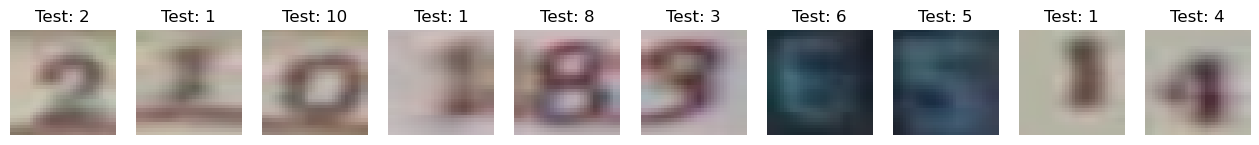

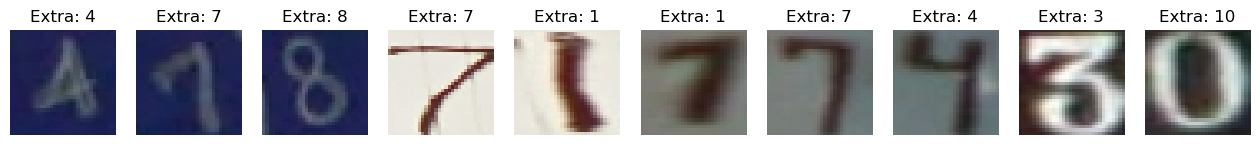

In [55]:
plotTrainImages(10)
plotTestImages(10)
plotExtraImages(10)

# Pre-processing

In [56]:
def preprocessImages():
    global train_images
    global train_labels
    global test_images
    global test_labels
    train_labels = np.where(train_labels==10, 0, train_labels)
    test_labels = np.where(test_labels==10, 0, test_labels)

    # Normalize the images.
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Plot histogram of mean pixel values
    num_labels = 10
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    for label in range(num_labels):
        # Find indexes of all images with the current label
        indexes = np.where(train_labels == label)[0]

        # Select images with the current label
        label_images = train_images[indexes]

        # Calculate the mean pixel value across all images of this label
        mean_pixels = np.mean(label_images, axis=0)

        # Calculate the overall mean across all pixels and color channels for simplification
        print(f"label = {label} : overall_mean_pixels = {np.mean(mean_pixels, axis=(0, 1, 2))}, overall_std_pixels = {np.std(mean_pixels, axis=(0, 1, 2))}")

        # Calculate the average across the RGB channels
        grayscale_image = np.mean(mean_pixels, axis=-1, keepdims=True)

        # Plot histogram of these mean pixel values
        ax = axs[label // 5, label % 5]  # Adjust for your layout
        ax.hist(grayscale_image.flatten(), bins=50, alpha=0.6)
        ax.set_title(f'Label {label}')
        ax.set_xlabel('Mean')
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Plot digit distribution in training dataset
    plt.figure()
    plt.hist(train_labels,  bins=20, alpha=0.6)
    plt.title("Training Digit's distribution in dataset")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.xticks(np.unique(train_labels))
    plt.show()

    # One-hot encode the labels
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)


In [57]:
print(f"Before preProcessing: train_image shape: {train_images.shape}")
print(f"Before preProcessing: train_labels shape: {train_labels.shape}")
print(f"Before preProcessing: test_labels shape: {test_labels.shape}")
print(f"Before preProcessing: test_images shape: {test_images.shape}")

Before preProcessing: train_image shape: (368095, 32, 32, 3)
Before preProcessing: train_labels shape: (368095,)
Before preProcessing: test_labels shape: (23542,)
Before preProcessing: test_images shape: (23542, 32, 32, 3)


label = 0 : overall_mean_pixels = 0.43536063742488945, overall_std_pixels = 0.0114835278627627
label = 1 : overall_mean_pixels = 0.43085706820968755, overall_std_pixels = 0.013152392835896887
label = 2 : overall_mean_pixels = 0.4321797636197607, overall_std_pixels = 0.014092902525809503
label = 3 : overall_mean_pixels = 0.43427933385865014, overall_std_pixels = 0.013480320559748937
label = 4 : overall_mean_pixels = 0.4346889657622559, overall_std_pixels = 0.013661153986459281
label = 5 : overall_mean_pixels = 0.43325493964371237, overall_std_pixels = 0.012929103461342482
label = 6 : overall_mean_pixels = 0.43346759945484853, overall_std_pixels = 0.011705542279857008
label = 7 : overall_mean_pixels = 0.43061549707430974, overall_std_pixels = 0.0147221750459756
label = 8 : overall_mean_pixels = 0.43664208766348045, overall_std_pixels = 0.011465357413101084
label = 9 : overall_mean_pixels = 0.43378287221386164, overall_std_pixels = 0.01123483687942804


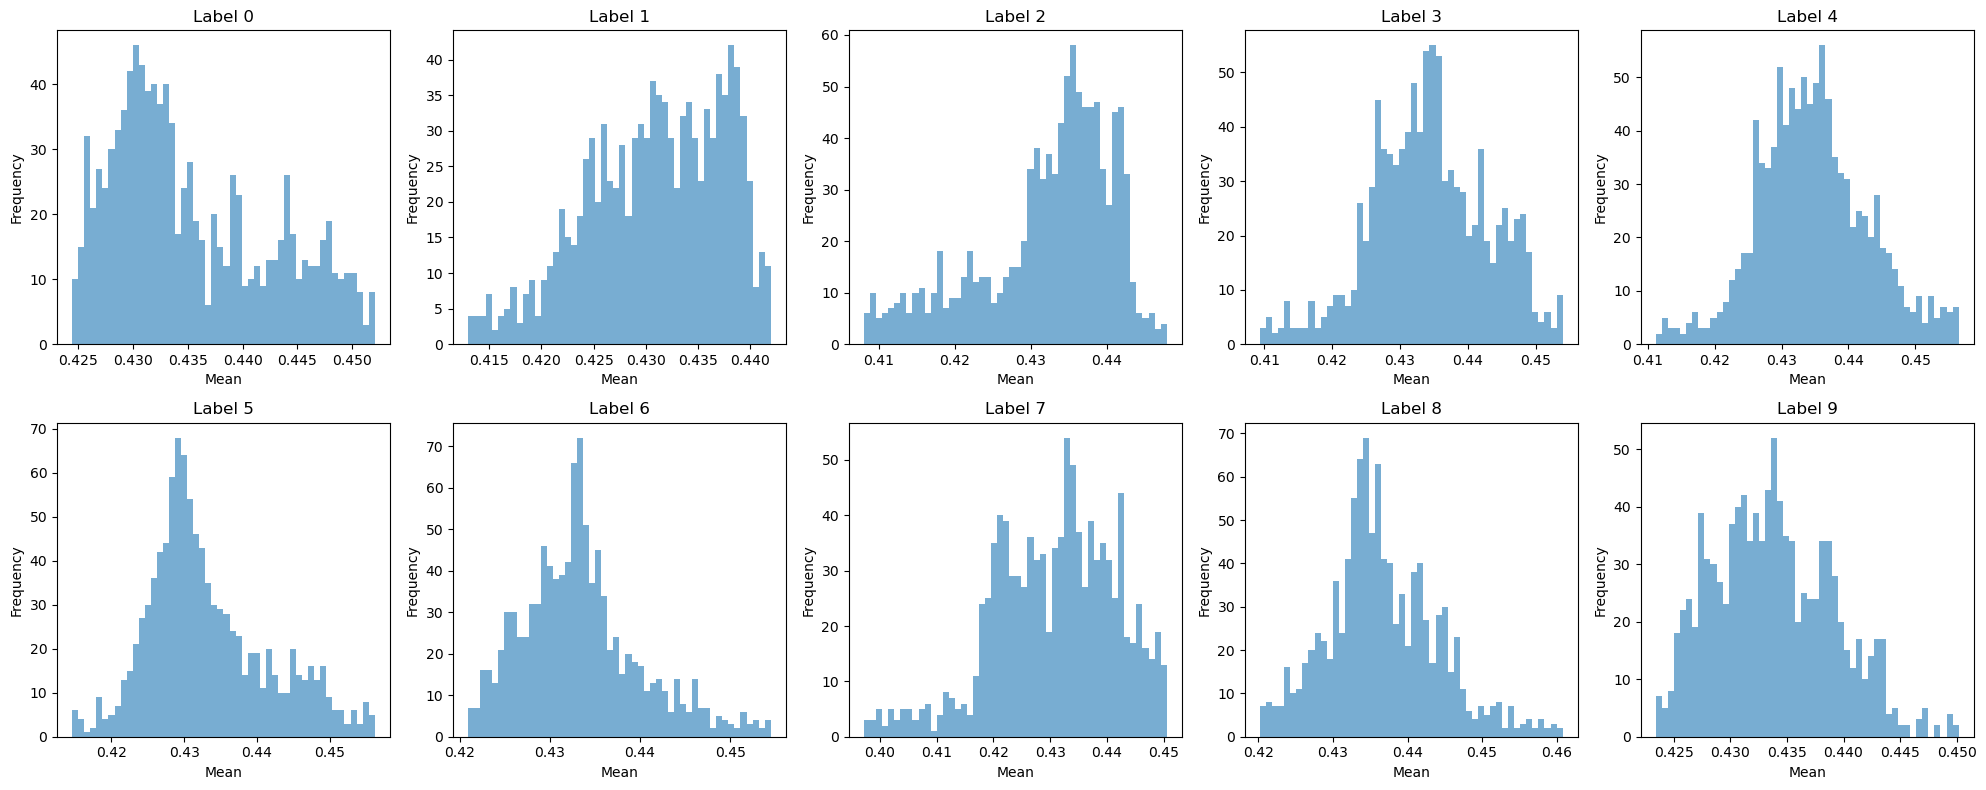

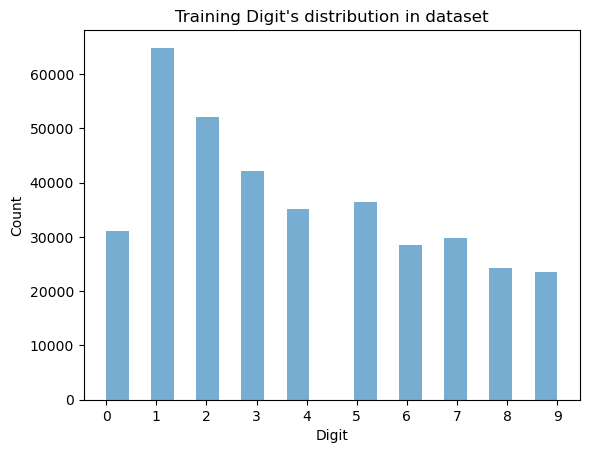

In [58]:
preprocessImages()

In [59]:
print(f"After preProcessing: train_image shape: {train_images.shape}")
print(f"After preProcessing: train_labels shape: {train_labels.shape}")
print(f"After preProcessing: test_labels shape: {test_labels.shape}")
print(f"After preProcessing: test_images shape: {test_images.shape}")

After preProcessing: train_image shape: (368095, 32, 32, 3)
After preProcessing: train_labels shape: (368095, 10)
After preProcessing: test_labels shape: (23542, 10)
After preProcessing: test_images shape: (23542, 32, 32, 3)


Split training data and labels into training (75%) and validation (25%) set

In [60]:
train_images_split, validation_images, train_labels_split, validation_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

In [61]:
print(f"After train/validation split train_images shape: {train_images_split.shape}")
print(f"After train/validation split train_labels shape: {train_labels_split.shape}")
print(f"After train/validation split validation_images shape: {validation_images.shape}")
print(f"After train/validation split validation_labels shape: {validation_labels.shape}")

After train/validation split train_images shape: (276071, 32, 32, 3)
After train/validation split train_labels shape: (276071, 10)
After train/validation split validation_images shape: (92024, 32, 32, 3)
After train/validation split validation_labels shape: (92024, 10)


Callback for early stopping

In [62]:
early_stopping = EarlyStopping(monitor='val_loss',
                                min_delta=0.001,
                                patience=8,
                                verbose=1,
                                mode='min',
                                restore_best_weights=True)

# VGG16 model architecture
Function for VGG16 without weight transfer learning model, will not use pre-trained weights.

In [70]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

def VGG16_noWeight():
    # Load VGG16 model, specify input shape, exclude top layer, and initialize without weights
    model = VGG16(include_top=False, input_shape=(32, 32, 3), weights=None)

    # Adding custom layers on top of VGG16
    x = model.output
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(10, activation='softmax')(x)
    # Creating the final model
    model_final = models.Model(inputs=model.input, outputs=predictions)
    return model_final


# CNN model architecture

In [74]:
def CNNModel():
    model_final = Sequential([
        Conv2D(32, kernel_size=(3,3),input_shape=(32, 32, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(rate = 0.2),

        Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(rate = 0.2),

        Conv2D(128, kernel_size=(3,3),activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(rate = 0.2),

        Conv2D(256, kernel_size=(3,3),activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(rate = 0.2),

        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(rate = 0.2),

        Dense(10, activation='softmax')
        ])
    return model_final

Function call for CNN model


In [75]:
model_final = CNNModel()

Set Adamax optimizer for training

In [76]:
from tensorflow.keras.optimizers import Adam
optimizer = tf.keras.optimizers.Adamax()


Compile the model

In [77]:
model_final.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training
Train the model with 25 epochs and batch of 80

In [78]:
history = model_final.fit(train_images_split, train_labels_split, epochs=25, validation_data=(validation_images, validation_labels), batch_size=80, callbacks=[early_stopping])
history = model_final.history

Epoch 1/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 61s 17ms/step - accuracy: 0.5740 - loss: 1.2334 - val_accuracy: 0.9425 - val_loss: 0.2003
Epoch 2/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 59s 17ms/step - accuracy: 0.9283 - loss: 0.2399 - val_accuracy: 0.9564 - val_loss: 0.1481
Epoch 3/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 60s 17ms/step - accuracy: 0.9467 - loss: 0.1812 - val_accuracy: 0.9643 - val_loss: 0.1261
Epoch 4/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 60s 17ms/step - accuracy: 0.9541 - loss: 0.1563 - val_accuracy: 0.9669 - val_loss: 0.1175
Epoch 5/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.9591 - loss: 0.1401 - val_accuracy: 0.9689 - val_loss: 0.1108
Epoch 6/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.9626 - loss: 0.1284 - val_accuracy: 0.9698 - val_loss: 0.1074
Epoch 7/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.9651 - loss: 0.1213 - val_accuracy: 0.9717 - val_loss: 0.1025
Epoch 8/25
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.9672 -

# Analysis
Plot training & validation accuracy


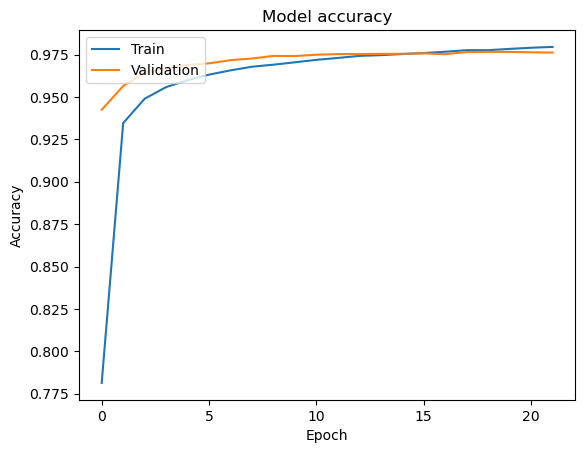

In [79]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Plot training & validation loss

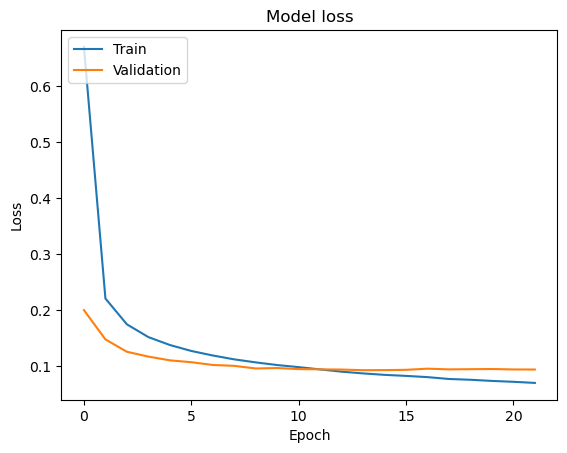

In [80]:
plt.figure()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate test dataset

In [81]:
test_loss, test_acc = model_final.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

736/736 - 3s - 4ms/step - accuracy: 0.9525 - loss: 0.1799

Test accuracy: 0.952510416507721


# Predict/Actual images and confidence level

In [82]:
# Predict the test images
predictions = model_final.predict(test_images)

736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Image 10969: predicted label = 8 with confidence level = 100.00 %  , Actual label = 8
Image 20847: predicted label = 4 with confidence level = 100.00 %  , Actual label = 4
Image 9549: predicted label = 1 with confidence level = 100.00 %  , Actual label = 1
Image 22364: predicted label = 9 with confidence level = 97.89 %  , Actual label = 9
Image 4256: predicted label = 6 with confidence level = 99.75 %  , Actual label = 6
Image 22237: predicted label = 8 with confidence level = 100.00 %  , Actual label = 8
Image 10006: predicted label = 2 with confidence level = 100.00 %  , Actual label = 2
Image 14087: predicted label = 0 with confidence level = 78.89 %  , Actual label = 0
Image 9998: predicted label = 2 with confidence level = 62.99 %  , Actual label = 2
Image 19194: predicted label = 5 with confidence level = 100.00 %  , Actual label = 5


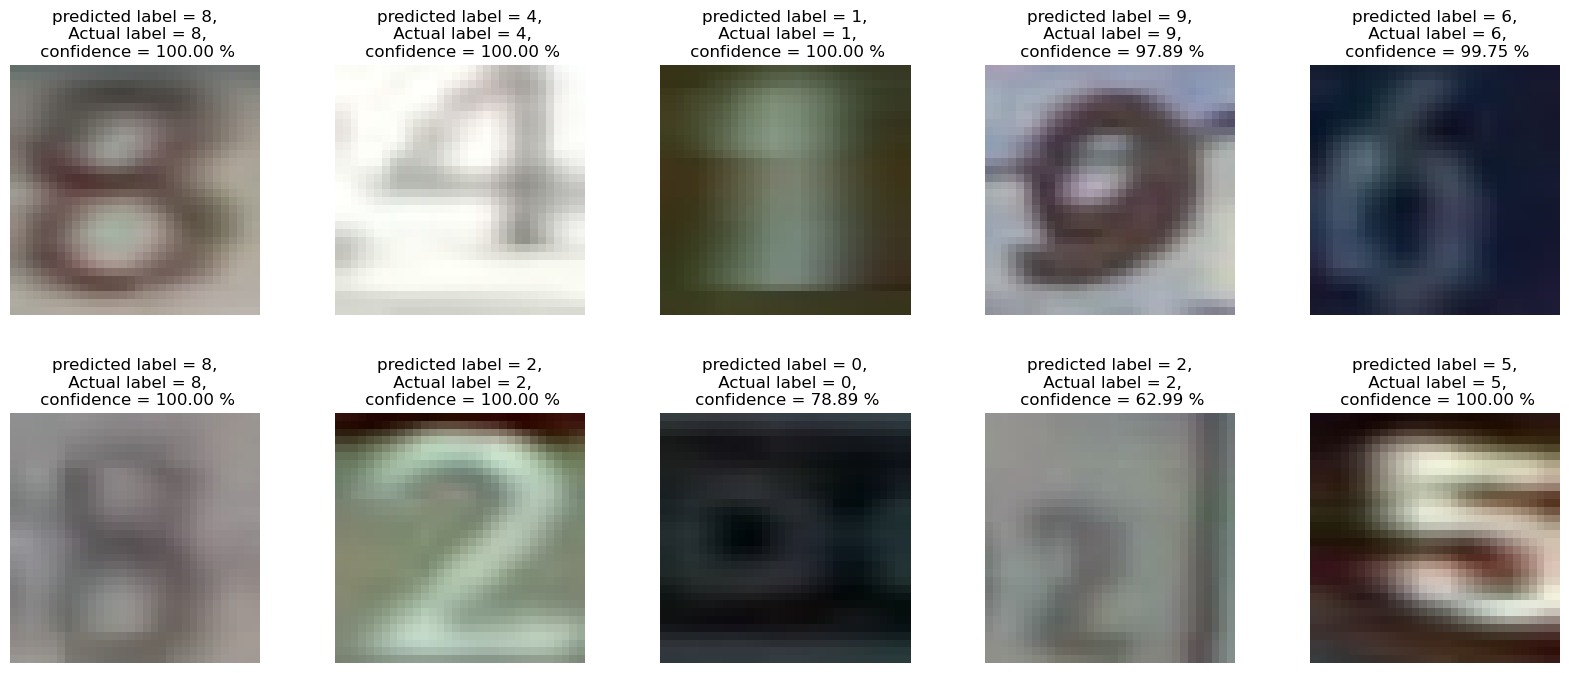

In [83]:
import random
random_numbers = random.sample(range(test_images.shape[0]), 10)
# Displaysome random results
n = 0
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
# Make space between plots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in zip(random_numbers, axs.flat):
    predicted_label = np.argmax(predictions[i])
    confidence = np.max(predictions[i])
    actual_label = np.where(test_labels[i] == 1)[0]
    ax.imshow(test_images[i], cmap= 'gray')
    ax.axis('off')
    ax.set_title(f'predicted label = {predicted_label},\n Actual label = {actual_label[0]},\n confidence = {confidence*100:.2f} %')
    print(f'Image {i}: predicted label = {predicted_label} with confidence level = {confidence*100:.2f} %  , Actual label = {actual_label[0]}')

plt.show()

Save Model

In [84]:
model_final.save('svhn_hyper_par_tuned_model_custom_layers.h5')

# Classification Report

In [85]:
from sklearn.metrics import classification_report
report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1) )
print(report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1733
           1       0.95      0.96      0.96      4903
           2       0.98      0.96      0.97      3745
           3       0.94      0.95      0.95      2582
           4       0.97      0.96      0.96      2289
           5       0.96      0.93      0.95      2073
           6       0.94      0.95      0.94      1699
           7       0.96      0.94      0.95      1777
           8       0.92      0.93      0.93      1402
           9       0.94      0.94      0.94      1339

    accuracy                           0.95     23542
   macro avg       0.95      0.95      0.95     23542
weighted avg       0.95      0.95      0.95     23542



# CNN Model architecture summary  

In [86]:
# Summary of the model
model_final.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,960,160 (7.48 MB)

 Trainable params: 653,386 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,306,774 (4.98 MB)

In [87]:
################### CNN ################################################